## Introduction

In this project, I've used various python tools and jupyter notebook to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First step is to import all the required libraries and utility functions.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Libraries are imported.')

Libraries are imported.


## Importing Data

The dataset is saved in a `data.csv` file.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mldata/buying_house.csv') #Importing csv file data.csv and storing the data in 'df'
names = df.columns
df.head() #Displaying the table

serial  date  age  distance  stores  latitude  longitude  price
0       0  2009   21         9       6        84        121  14264
1       1  2007    4         2       3        86        121  12032
2       2  2016   18         3       7        90        120  13560
3       3  2002   13         2       2        80        128  12029
4       4  2014   25         5       8        81        122  14157

In [ ]:
sns.distplot(df['price'])

<ipython-input-5-86c1ddc3c66a>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<Axes: xlabel='price', ylabel='Density'>

<Axes: >

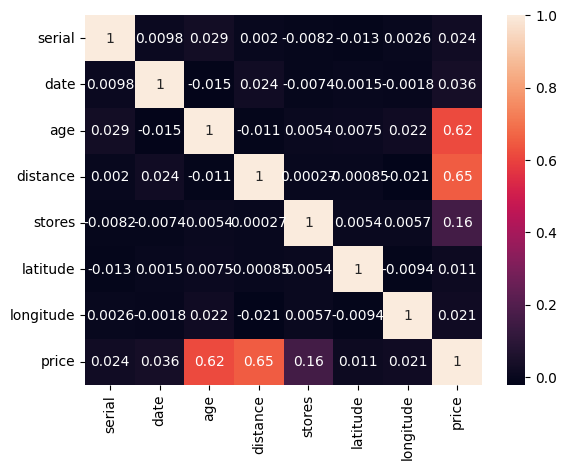

In [ ]:
sns.heatmap(df.corr(),annot = True) #Just to see the correlation between the features and the label

## Checking For Missing Data


In [ ]:
df.isna().sum() # isna() gives true or false value (1/0) if the data in the column is missing or present respectively
                # sum() then counts the total missing fields in all columns

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

## Data Normalization

Data is normalized so as to bring all the different features to a similar range, thus to make it easier for optimization algorithms to find minimas.

In [ ]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std() #Data is normalized by subtracting each value in the column with the mean value and then dividing it with the standard                                                 deviation of the whole column
df_norm.head()

date       age  distance    stores  latitude  longitude     price
0  0.015978  0.181384  1.257002  0.345224 -0.307212  -1.260799  0.350088
1 -0.350485 -1.319118 -0.930610 -0.609312  0.325301  -1.260799 -1.836486
2  1.298598 -0.083410 -0.618094  0.663402  1.590328  -1.576456 -0.339584
3 -1.266643 -0.524735 -0.930610 -0.927491 -1.572238   0.948803 -1.839425
4  0.932135  0.534444  0.006938  0.981581 -1.255981  -0.945141  0.245266

Convert Label Value Back To Original:

The Labelvalues are normalized, thus we'll get predictions from the trained model in the same range and are required to be original range.

In [ ]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):       #Defining a function which will convert the label values back to the original distribution and return it
    return int(pred * y_std + y_mean)


## Creating Training and Test Sets

Select Features:

First we'll remove the last 'price' column and select all other columns as the feature.(Last column is the label)

In [ ]:
X = df_norm.iloc[:, :6] #Storing the features in 'X'
X.head()

date       age  distance    stores  latitude  longitude
0  0.015978  0.181384  1.257002  0.345224 -0.307212  -1.260799
1 -0.350485 -1.319118 -0.930610 -0.609312  0.325301  -1.260799
2  1.298598 -0.083410 -0.618094  0.663402  1.590328  -1.576456
3 -1.266643 -0.524735 -0.930610 -0.927491 -1.572238   0.948803
4  0.932135  0.534444  0.006938  0.981581 -1.255981  -0.945141

Select Labels:

Now we'll select and store the last column as the Labels.

In [ ]:
Y = df_norm.iloc[:, -1] #Storing the labels in 'Y'
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

Feature and Label Values:

We will now just extract the numeric values for the features and labels.

In [ ]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape) #'shape' gives the dimension of the entity
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


Train and Test Split:

We will keep some part of the data aside as a test set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)
#This predefined function splits the dataset to train and test set, where test size is given in 'test_size'(Here 5%)
#Random state ensures that the splits that you generate are reproducible. Scikit-learn uses random permutations to generate the splits.

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


## Creating the Model

Defining the Model:

Here a function is defined that returns an untrained neural network model of a certain architecture. Here I've created a model with 2 hidden layers.

Input layer consists of 10 neurons (10*(6+1) = 70 weights/parameters), hidden layers consists of 20 (20*(10+1)=220 weights/parameters) and 5 (5*(20+1)=105 weights/parameters) neurons respectively (Extra 1 Input to neurons is the biased unit).

A neural network without an activation function is essentially just a linear regression model. The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks. Since it is a regression problem 'relu' (Rectified linear unit) is used.

In [ ]:
def get_model():

    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'), #10 neurons, Input Layer
        Dense(20, activation = 'relu'),                     #20 neurons, Hidden Layer
        Dense(5, activation = 'relu'),                      #5  neurons, Hidden Layer
        Dense(1)                                            #Output Layer
    ])                                                      #'relu' activation

    model.compile(
        loss='mse',                                         #Trained using Mean square error loss (Cost function)
        optimizer='adam'                                    #Optimizer used is 'adam' (One of the Fastest optimizers)
    )

    return model

model = get_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

EarlyStopping callback is used from Keras to stop the model training if the validation loss stops decreasing for a few epochs (Here, after 5 epochs).

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5) #Defining early stopping parameter (optional, to save time)

model = get_model()

preds_on_untrained = model.predict(X_test) #Make predictions on the test set before training the parameters

#Finally training the model-->
history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping]
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8843 - val_loss: 0.2596
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2464 - val_loss: 0.1726
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1849 - val_loss: 0.1633
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1749 - val_loss: 0.1618
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1645 - val_loss: 0.1606
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1610 - val_loss: 0.1592
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1605 - val_loss: 0.1563
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1578 - val_loss: 0.1568
Epoch 9/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1562 - val_loss: 0.1561
Epoch 10/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1560 - val_loss: 0.1572
Epoch 11/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1558 - val_loss: 0.1554
Epo

Plotting Training and Validation Loss:

The 'plot_loss' helper function is used to take a look training and validation loss.

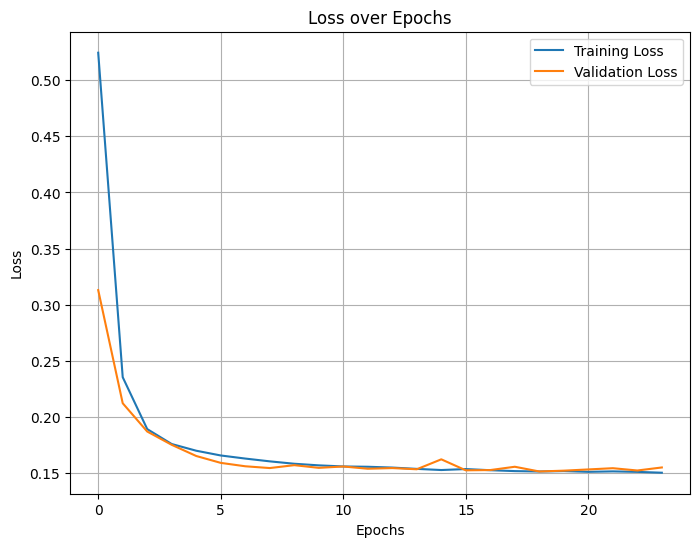

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plots training and validation loss from the Keras model's history.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Use the function after training your model
plot_loss(history)


## Final Predictions

Plotting Raw Predictions:

The 'compare_predictions' helper function is used to compare predictions made from the trained and the untrained model.

In [ ]:
preds_on_trained = model.predict(X_test)



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Plot Price Predictions:

The raw predictions are converted to price predictions using 'convert_label_value' defined earlier.
The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

In [ ]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]



<ipython-input-5-48acff8e81c9>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(pred * y_std + y_mean)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_test, preds_on_trained)
mae = mean_absolute_error(y_test, preds_on_trained)
r2 = r2_score(y_test, preds_on_trained)

# Display metrics
print("Model Accuracy Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Model Accuracy Metrics:
Mean Squared Error (MSE): 0.16
Mean Absolute Error (MAE): 0.34
R² Score: 0.82


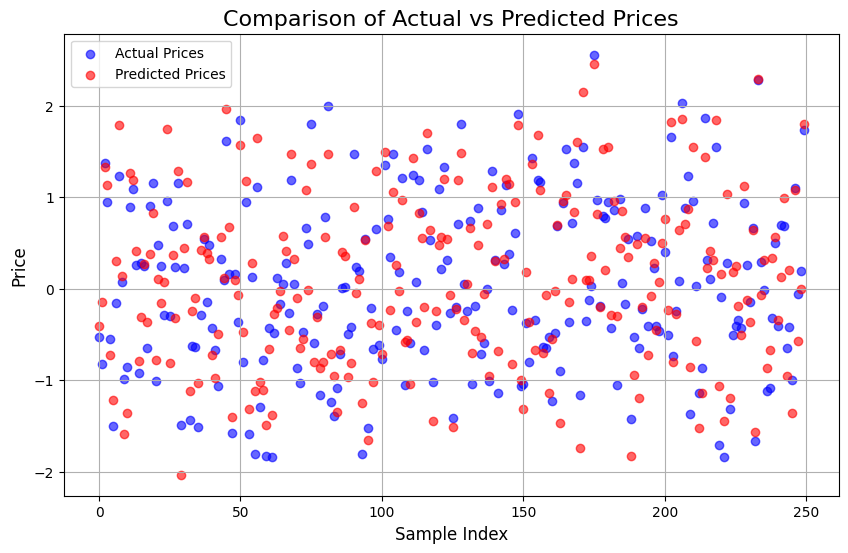

In [ ]:
import matplotlib.pyplot as plt

# Visualize predictions vs actual values
def plot_predictions(y_test, preds_on_trained):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Prices', alpha=0.6)
    plt.scatter(range(len(preds_on_trained)), preds_on_trained, color='red', label='Predicted Prices', alpha=0.6)
    plt.title('Comparison of Actual vs Predicted Prices', fontsize=16)
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot predictions
plot_predictions(y_test, preds_on_trained)


In [ ]:
# Install Anvil Uplink
!pip install anvil-uplink

# Import the library and connect to Anvil
import anvil.server


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00


In [ ]:

# Replace with your Anvil Uplink key
anvil.server.connect("server_4NINEPK6AH3ZEAJV553SJSDV-F5PBTRZXU7VHHVL2")

@anvil.server.callable
def predict_house_price(features):
    """
    Function to receive features from the Anvil app, make predictions,
    and return the predicted house price.
    """
    import numpy as np

    # Normalize the user input features
    mean_values = df.mean()
    std_values = df.std()
    normalized_features = (np.array(features) - mean_values[:6].values) / std_values[:6].values

    # Make predictions using the trained model
    predicted_price_normalized = model.predict(normalized_features.reshape(1, -1))[0][0]

    # Convert the normalized prediction to the original price range
    predicted_price = convert_label_value(predicted_price_normalized)

    return predicted_price


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [ ]:
anvil.server.wait_forever()